<table>
    <tr>
        <th><img src="img/rqc.png" href="http://www.rqc.ru/" width="150px"></th>
        <th colspan="3" align="left" style="font-weight:normal">
            <p>• Yaroslav Kharkov <a href="mailto:y.kharkov@unsw.edu.au">y.kharkov@unsw.edu.au</a>, Anton Karazeev <a href="mailto:a.karazeev@rqc.ru">a.karazeev@rqc.ru</a>
            <p>• Based on <a href="https://www.nature.com/articles/s41567-018-0048-5">Neural-network quantum state tomography</a> paper</p>
            <p>• The latest version of this notebook is available <a href="https://github.com/RQC-QApp/NNQST">here</a></p>
        </th>
    </tr>
</table>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

from nnqst import rbm_qst, utils, paper_functions, generators,\
    state_operations, state_representations, fidelities

## RBM QST

In [34]:
num_units = 2
num_hidd = 5
num_samples = 3000

states = generators.get_all_states(num_units, "tuple")
phases_sampled = 0.1 * generators.random_phases(len(states))
# phases_sampled = generators.random_phases(len(states))
# phases_sampled = np.array([2.62022653e-01, 4.52593227e-01, 7.18638172e-05, 1.89961158e-01])
# phases_sampled = [1.4, 0.9, 0.3, 2.7]

# Filling dicts.
amplitudes, phases = {}, {}
for i in range(len(states)):
    amplitudes[states[i]] = 1. / np.sqrt(len(states))
    phases[states[i]] = phases_sampled[i]

print('> amplitudes:', amplitudes)
print("> phases:", phases)
print(' ')

dataset = generators.generate_Isinglike_dataset(num_units, states, amplitudes, phases, num_samples)

psi_true = dict()
for state in states:
    psi_true[state] = amplitudes[state] * np.exp(1j * phases[state])

print('> psi_true: ', psi_true)
print(' ')
print('> dataset:', dataset)

> amplitudes: {(0, 0): 0.5, (0, 1): 0.5, (1, 0): 0.5, (1, 1): 0.5}
> phases: {(0, 0): 0.3940113984692327, (0, 1): 0.4483778201208066, (1, 0): 0.6148409106764856, (1, 1): 0.19541989155563555}
 
> psi_true:  {(0, 0): (0.4616882676141003+0.19194776254880094j), (0, 1): (0.4505757548161938+0.2167521376407099j), (1, 0): (0.4084326122527069+0.2884142875247861j), (1, 1): (0.4904831110682235+0.09708922575052664j)}
 
> dataset: {'HI': {(0, 1): 1416, (0, 0): 1545, (1, 1): 26, (1, 0): 13}, 'IH': {(1, 0): 1407, (0, 0): 1533, (1, 1): 60}, 'KI': {(1, 0): 596, (0, 0): 913, (1, 1): 951, (0, 1): 540}, 'IK': {(0, 0): 802, (1, 0): 451, (1, 1): 1011, (0, 1): 736}}


## (1/2) Amplitudes.

In [35]:
dataset_Z = generators.generate_dataset(states, ['I' * num_units], amplitudes, phases, num_samples)

quantum_basis = states
r_qst = rbm_qst.RBM_QST(quantum_basis, num_units, num_hidd)
r_qst.train_amplitudes(dataset_Z, max_epochs=1000, learning_rate=0.9, debug=True, precise=True)

Epoch 0: objective is 1.3862275124468637
Epoch 500: objective is 1.386058959947601


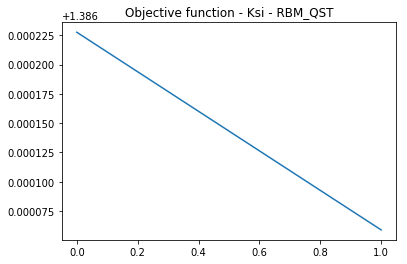

In [36]:
plt.plot(r_qst.objectives)
plt.title('Objective function - Ksi - RBM_QST')
plt.show()

In [37]:
# Fidelity.
fid, sampled_from_RBM = fidelities.fidelity_RBM(r_qst, psi_true, num_samples=2000)
fid

0.9768795837287464

In [38]:
sampled_from_RBM

{(0, 0): 0.49598387070548977,
 (0, 1): 0.5,
 (1, 0): 0.5229722745997153,
 (1, 1): 0.4801041553663122}

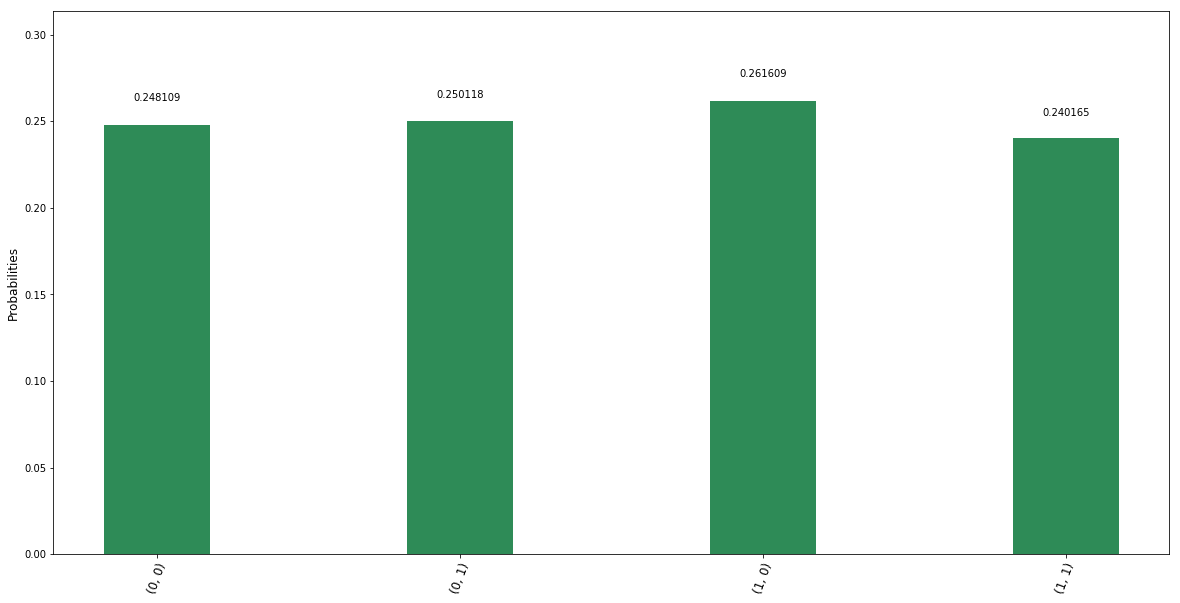

In [39]:
utils.plot_histogram(sampled_from_RBM)

In [40]:
print(r_qst.weights_lambda)

[[ 0.00000000e+00  3.03939618e-04  2.05245130e-04 -3.27174872e-04
  -8.89076257e-05 -4.53643762e-05]
 [-5.94796788e-03 -3.54692337e-02  6.96074213e-02  4.78853698e-02
   1.67922998e-02 -6.31913564e-02]
 [-1.57847562e-02 -7.52933747e-02 -7.98966666e-02  6.51830090e-02
   1.27581153e-02  2.21854482e-02]]


## (2/2) Phases.

In [41]:
basis_set = generators.generate_Isinglike_basis_set(num_units)
print('> basis_set:', basis_set)

print('> dataset:', dataset)

> basis_set: ['HI', 'IH', 'KI', 'IK']
> dataset: {'HI': {(0, 1): 1416, (0, 0): 1545, (1, 1): 26, (1, 0): 13}, 'IH': {(1, 0): 1407, (0, 0): 1533, (1, 1): 60}, 'KI': {(1, 0): 596, (0, 0): 913, (1, 1): 951, (0, 1): 540}, 'IK': {(0, 0): 802, (1, 0): 451, (1, 1): 1011, (0, 1): 736}}


In [42]:
r_qst.train_phases(dataset, basis_set=basis_set, max_epochs=1000,
                   learning_rate=0.05, debug=True, precise=True)

Epoch 0: objective is 1.1090512680161724
Epoch 500: objective is 1.0822725906659072


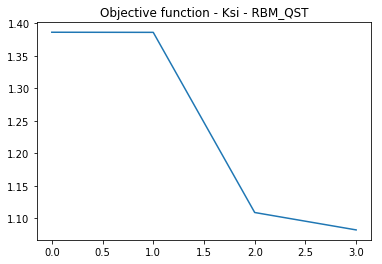

In [43]:
plt.plot(r_qst.objectives)
plt.title('Objective function - Ksi - RBM_QST')
plt.show()

In [44]:
# Fidelity.
fid = fidelities.fidelity_RBM_PRECISE(r_qst, psi_true)
print('precise:', fid)

fid, sampled_from_RBM = fidelities.fidelity_RBM(r_qst, psi_true, num_samples=2000)
print('sampled:', fid)

precise: 0.9810095863709763
sampled: 0.9775846096848502


In [45]:
r_qst.weights_mu

array([[ 0.        ,  0.00440949,  0.0014478 , -0.00433462, -0.00107377,
         0.00092286],
       [-0.12078488, -0.1428825 ,  0.03005451, -0.00478862, -0.11504669,
        -0.118937  ],
       [-0.17771666, -0.14169364, -0.12639551, -0.0904719 , -0.10318798,
        -0.12411307]])

In [46]:
# Phases
psi_rbm_lst = list(utils.psi_RBM(r_qst).values())
psi_true_lst = list(psi_true)
print(psi_true_lst)
phases_RBM = np.log(psi_rbm_lst).imag
phases_true = np.array(list(phases.values()))
print(phases_RBM%np.pi)
print(phases_true%np.pi)
print(np.array(phases_true - phases_RBM)%(2*np.pi))

[(0, 0), (0, 1), (1, 0), (1, 1)]
[1.73321354 1.5022277  1.58789529 1.36232186]
[0.3940114  0.44837782 0.61484091 0.19541989]
[4.94398317 5.22933542 5.31013093 5.11628334]


In [47]:
phases_true

array([0.3940114 , 0.44837782, 0.61484091, 0.19541989])

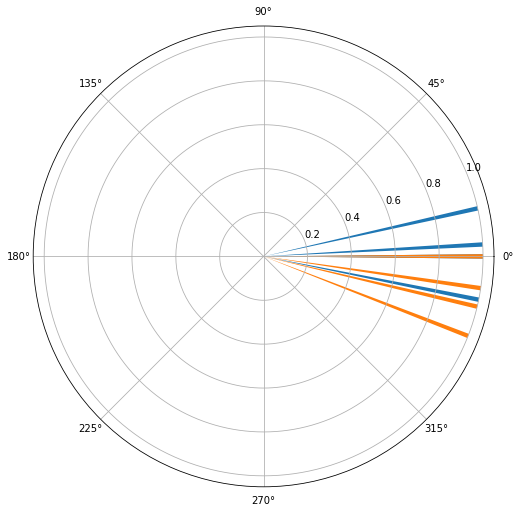

In [48]:
radii = np.ones(4)
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
ax.bar(phases_true - phases_true[0], radii, width=0.02, bottom=0.0)
ax.bar(phases_RBM - phases_RBM[0], radii, width=0.02, bottom=0.0)
plt.show()